In [ ]:
pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 44.7 MB/s eta 0:00:00


In [ ]:
pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 kB 12.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces


def usable_ace(hand):
    """Verifica si un As puede usarse como 11 sin que la mano supere 21."""
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):
    """Calcula el total de la mano, considerando el valor del As."""
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


class BlackjackEnv(gym.Env):
    """
    Entorno personalizado de Blackjack basado en Gymnasium.

    Simula un entorno de Blackjack con reglas específicas y soporte
    para conteo de cartas utilizando el método Hi-Lo.
    """
    def __init__(self):
        super(BlackjackEnv, self).__init__()

        # Inicialización de variables de estado y parámetros del entorno
        self.true_count = 0             # Conteo verdadero basado en cartas vistas
        self.running_count = 0          # Conteo acumulado de cartas según Hi-Lo
        self.deck = []                  # Mazo de cartas
        self.step_count = 0             # Contador de pasos por ronda
        self.max_steps = 100            # Máximo de pasos por ronda
        self.round_over = False         # Estado de la ronda actual
        self.first_move = True          # Indica si es el primer movimiento de la ronda
        self.cut_card_position = None   # Posición de la carta de corte en el mazo
        self.cut_card_reached = False   # Estado de la carta de corte alcanzada
        self.log = []                   # Registro de eventos del entorno

        # Configuración de apuestas
        self.bet_levels = [10, 20, 30]          # Opciones de apuesta
        self.current_bet = self.bet_levels[0]   # Apuesta actual
        self.min_bet = self.bet_levels[0]       # Apuesta mínima
        self.max_bet = self.bet_levels[-1]      # Apuesta máxima
        self.next_bet = self.bet_levels[0]      # Apuesta para la próxima ronda

        # Espacios de acción y observación
        self.action_space = spaces.Discrete(3)  # Acciones: plantarse, pedir, doblar
        self.observation_space = spaces.Box(
            low=np.array([0, 0, -10, 0]),
            high=np.array([32, 11, 10, 1]),
            dtype=np.float32,
        )

        # Barajar el mazo inicial
        self.shuffle_deck()

    def shuffle_deck(self):
        """Barajar el mazo y reiniciar el conteo."""
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 8 * 4
        np.random.shuffle(self.deck)

        # Establecer la posición de la carta de corte entre el 50% y el 65% del mazo
        deck_size = len(self.deck)
        self.cut_card_position = np.random.randint(int(deck_size * 0.5), int(deck_size * 0.65))
        self.log.append(f"[DEBUG] Posición de la carta de corte establecida: {self.cut_card_position}")
        self.cut_card_reached = False

        # Reiniciar conteo y log
        self.running_count = 0
        self.true_count = 0
        self.log = []
        self.log.append("[SHUFFLE] Mazo barajado, conteo reiniciado.")

    def draw_card(self):
        """Robar una carta del mazo y verificar la carta de corte."""
        card = self.deck.pop()

        # Verificar si alcanzamos la carta de corte
        if len(self.deck) <= self.cut_card_position and not self.cut_card_reached:
            self.cut_card_reached = True
            self.log.append(f"[CUT CARD] Se alcanzó la carta de corte en posición {len(self.deck)}.")

        # Actualizar el conteo de cartas
        self.update_running_count([card])

        self.log.append(f"[DRAW CARD] Carta robada: {card}")
        return card


    def reset(self, seed=None, options=None):
        """
        Reinicia el entorno para una nueva ronda.
        """
        if seed is not None:
            np.random.seed(seed)

        if self.cut_card_reached:
            self.log.append("[RESET] Barajando el mazo después de alcanzar la carta de corte.")
            self.shuffle_deck()
            self.cut_card_reached = False

        # Reinicia todos los parámetros de la ronda
        self.round_over = False
        self.step_count = 0
        self.first_move = True

        # Reparto inicial de cartas
        self.player_cards = [self.draw_card(), self.draw_card()]
        self.player_sum = sum_hand(self.player_cards)
        self.dealer_card = self.draw_card()
        self.dealer_cards = [self.dealer_card]

        self.player_blackjack = self._is_blackjack(self.player_cards)
        self.dealer_blackjack = self._is_blackjack(self.dealer_cards)
        self.current_bet = self.next_bet

        self.log.append(f"[RESET] Mano del jugador: {self.player_cards}, Carta del dealer: {self.dealer_card}")
        return self._get_obs(), {}

    def _is_blackjack(self, hand):
        """Determina si la mano tiene un Blackjack."""
        return len(hand) == 2 and sum_hand(hand) == 21

    def dealer_play(self):
        """Lógica para el turno del dealer."""
        # El dealer roba su carta 2 al inicio de su turno
        self.dealer_hidden_card = self.draw_card()
        self.dealer_cards.append(self.dealer_hidden_card)
        self.log.append(f"[DEALER] Carta 2 del dealer: {self.dealer_hidden_card}")
        self.dealer_blackjack = self._is_blackjack(self.dealer_cards)

        if not self._is_blackjack(self.dealer_cards) and not self._is_blackjack(self.player_cards):
            while sum_hand(self.dealer_cards) < 17:
                card = self.draw_card()
                self.dealer_cards.append(card)

        self.log.append(f"[DEALER] Cartas del dealer: {self.dealer_cards}")

    def step(self, action):
        """Realiza una acción del jugador."""
        reward = 0
        terminated = False
        truncated = False

        # Incrementar contador de pasos
        self.step_count += 1
        if self.step_count > self.max_steps:
            truncated = True
            reward = -self.current_bet
            return self._get_obs(), reward, terminated, truncated, {}

        # Evaluar si el jugador tiene Blackjack
        if self.player_blackjack:
            self.round_over = True
            self.log.append("[PLAYER] Blackjack detectado, paso al dealer.")
            self.dealer_play()
            reward = self._calculate_reward()
            self.calculate_true_count()
            self.adjust_bet()
            terminated = True
            return self._get_obs(), reward, terminated, truncated, {}

        # Acciones del jugador
        if action == 0:  # Stand
            self.log.append("[ACTION] Stand")
            self.round_over = True
        elif action == 1:  # Hit
            self.log.append("[ACTION] Hit")
            card = self.draw_card()
            self.player_cards.append(card)
            self.player_sum = sum_hand(self.player_cards)
            self.first_move = False
            self.log.append(f"[PLAYER] Carta añadida: {card}, Mano actual: {self.player_cards}")

            # Si el jugador alcanza o supera 21, finaliza su turno
            if self.player_sum >= 21:
                self.log.append("[PLAYER] Mano alcanza o supera 21, turno finalizado.")
                self.round_over = True
        elif action == 2:  # Double
            self.log.append("[ACTION] Double")
            if self.first_move:
                card = self.draw_card()
                self.player_cards.append(card)
                self.player_sum = sum_hand(self.player_cards)
                self.current_bet = self.current_bet * 2
                self.first_move = False
                self.round_over = True
                self.log.append(f"[PLAYER] Carta añadida: {card}, Mano actual: {self.player_cards}, Apuesta actual: {self.current_bet}")
            else:
                card = self.draw_card()
                self.player_cards.append(card)
                self.player_sum = sum_hand(self.player_cards)
                self.first_move = False
                self.log.append(f"[PLAYER] Carta añadida: {card}, Mano actual: {self.player_cards}")
                if self.player_sum >= 21:
                    self.round_over = True

        # Si el jugador se pasa, dealer gana automáticamente
        if self.player_sum > 21:
            self.log.append("[PLAYER] Mano se pasa de 21, dealer gana automáticamente.")
            reward = -self.current_bet
            self.calculate_true_count()
            self.adjust_bet()
            terminated = True
            return self._get_obs(), reward, terminated, truncated, {}

        # Si la ronda ha terminado
        if self.round_over:
            self.dealer_play()
            reward = self._calculate_reward()
            self.calculate_true_count()
            self.adjust_bet()
            terminated = True

        return self._get_obs(), reward, terminated, truncated, {}

    def adjust_bet(self):
        """Ajusta la apuesta para la próxima ronda según el true count."""
        if self.true_count < 1:
            self.next_bet = self.bet_levels[0]
        elif 1 <= self.true_count < 3:
            self.next_bet = self.bet_levels[1]
        else: # self.true_count > 3:
            self.next_bet = self.bet_levels[2]
        self.log.append(f"[ADJUST BET] Nueva apuesta establecida: {self.next_bet}")

    def update_running_count(self, cards):
        """Actualizar el conteo de cartas vistas."""
        hilo_values = {2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: -1, 1: -1}
        for card in cards:
            self.running_count += hilo_values.get(card, 0)

    def calculate_true_count(self):
        """Calcular el true count basado en el conteo actual y el mazo restante según el método Hi-Lo."""
        remaining_decks = len(self.deck) / 52
        if remaining_decks > 0:
            self.true_count = self.running_count / (remaining_decks * 2)
        else:
            self.true_count = 0
        self.log.append(f"[TRUE COUNT] Remaining decks: {remaining_decks}, Running count: {self.running_count}, True count: {self.true_count}")


    def _get_obs(self):
        """Devuelve la observación actual."""
        has_usable_ace = 1 if usable_ace(self.player_cards) else 0
        return np.array([self.player_sum, self.dealer_card, self.true_count, has_usable_ace], dtype=np.float32)

    def _calculate_reward(self):
        """Calcula el resultado de la ronda."""
        # Recompensas específicas para Blackjack
        if self.player_blackjack:
            if self.dealer_blackjack:
                return 0  # Empate
            else:
                return self.current_bet * 1.5
        elif self.dealer_blackjack:
            return -self.current_bet

        # Recompensas estándar
        if self.player_sum > 21:
            return -self.current_bet
        elif sum_hand(self.dealer_cards) > 21 or self.player_sum > sum_hand(self.dealer_cards):
            return self.current_bet
        elif self.player_sum < sum_hand(self.dealer_cards):
            return -self.current_bet
        return 0


In [ ]:
env = BlackjackEnv()
for _ in range(300):  # Robar muchas cartas
    card = env.draw_card()
    if env.cut_card_reached:
        print(f"Carta de corte alcanzada en posición {len(env.deck)}")
        break

Carta de corte alcanzada en posición 253


In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.9 MB/s eta 0:00:00


In [ ]:
pip install sb3-contrib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 9.0 MB/s eta 0:00:00


In [ ]:
from sb3_contrib import QRDQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
import optuna

# Crear el entorno de evaluación
eval_env = DummyVecEnv([lambda: Monitor(BlackjackEnv())])

# Configurar el callback de evaluación
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./logs_qrdqn/",
    log_path="./logs_qrdqn/",
    eval_freq=5000,
    n_eval_episodes=10,
    deterministic=True,
    render=False
)

# Crear el entorno principal
train_env = DummyVecEnv([lambda: Monitor(BlackjackEnv())])

# Función para buscar los mejores hiperparámetros con Optuna
def objective(trial):
    # Sugerir hiperparámetros
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    buffer_size = trial.suggest_int('buffer_size', 10000, 100000, log=True)
    batch_size = trial.suggest_int('batch_size', 32, 512, log=True)
    gamma = trial.suggest_float('gamma', 0.8, 0.999)
    exploration_fraction = trial.suggest_float('exploration_fraction', 0.1, 0.5)
    exploration_final_eps = trial.suggest_float('exploration_final_eps', 0.01, 0.1)
    gradient_steps = trial.suggest_int('gradient_steps', 1, 100, log=True)

    # Configurar el modelo QRDQN con los hiperparámetros sugeridos
    model = QRDQN(
        policy="MlpPolicy",
        env=train_env,
        learning_rate=learning_rate,
        buffer_size=buffer_size,
        batch_size=batch_size,
        gamma=gamma,
        exploration_fraction=exploration_fraction,
        exploration_final_eps=exploration_final_eps,
        gradient_steps=gradient_steps,
        verbose=0
    )

    # Entrenar el modelo
    model.learn(total_timesteps=50000, callback=eval_callback)

    # Evaluar el modelo en el entorno de evaluación
    mean_reward = 0
    for _ in range(10):  # Evaluar en 10 episodios
        obs = eval_env.reset()
        done = False
        episode_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _ = eval_env.step(action)
            episode_reward += reward
        mean_reward += episode_reward
    mean_reward /= 10

    return mean_reward

# Crear el estudio de Optuna para optimizar los hiperparámetros
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Imprimir los mejores parámetros
best_params = study.best_params
print("Best hyperparameters:", best_params)



[I 2025-01-26 10:02:22,589] A new study created in memory with name: no-name-26e57dde-ee61-4e7c-8248-cab2cf45d472


Eval num_timesteps=5000, episode_reward=-1.50 +/- 10.50
Episode length: 1.10 +/- 0.30
New best mean reward!
Eval num_timesteps=10000, episode_reward=-2.00 +/- 9.80
Episode length: 1.50 +/- 0.50
Eval num_timesteps=15000, episode_reward=-4.00 +/- 9.17
Episode length: 1.20 +/- 0.40
Eval num_timesteps=20000, episode_reward=-2.00 +/- 9.80
Episode length: 1.60 +/- 0.66
Eval num_timesteps=25000, episode_reward=-3.00 +/- 9.00
Episode length: 1.30 +/- 0.46
Eval num_timesteps=30000, episode_reward=-3.00 +/- 9.00
Episode length: 1.60 +/- 0.49
Eval num_timesteps=35000, episode_reward=-3.00 +/- 9.00
Episode length: 1.30 +/- 0.64
Eval num_timesteps=40000, episode_reward=2.00 +/- 9.80
Episode length: 1.20 +/- 0.40
New best mean reward!
Eval num_timesteps=45000, episode_reward=-0.50 +/- 10.11
Episode length: 1.40 +/- 0.49


/usr/local/lib/python3.11/dist-packages/optuna/study/_tell.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(v)
[I 2025-01-26 10:03:26,920] Trial 0 finished with value: -1.0 and parameters: {'learning_rate': 0.0007692162838528328, 'buffer_size': 66465, 'batch_size': 94, 'gamma': 0.9508559951424712, 'exploration_fraction': 0.3861009373537765, 'exploration_final_eps': 0.08176070983952997, 'gradient_steps': 1}. Best is trial 0 with value: -1.0.


Eval num_timesteps=50000, episode_reward=-7.00 +/- 12.69
Episode length: 1.40 +/- 0.49
Eval num_timesteps=5000, episode_reward=7.00 +/- 6.40
Episode length: 1.30 +/- 0.46
New best mean reward!
Eval num_timesteps=10000, episode_reward=0.00 +/- 10.00
Episode length: 1.50 +/- 0.50
Eval num_timesteps=15000, episode_reward=0.00 +/- 8.94
Episode length: 1.50 +/- 0.67
Eval num_timesteps=20000, episode_reward=-6.00 +/- 8.00
Episode length: 1.30 +/- 0.46
Eval num_timesteps=25000, episode_reward=0.50 +/- 10.59
Episode length: 1.80 +/- 0.87
Eval num_timesteps=30000, episode_reward=-3.00 +/- 9.00
Episode length: 1.70 +/- 0.64
Eval num_timesteps=35000, episode_reward=0.00 +/- 10.00
Episode length: 1.40 +/- 0.66
Eval num_timesteps=40000, episode_reward=-2.00 +/- 9.80
Episode length: 1.90 +/- 0.94
Eval num_timesteps=45000, episode_reward=-2.00 +/- 8.72
Episode length: 1.60 +/- 0.66


[I 2025-01-26 10:05:22,812] Trial 1 finished with value: -2.0 and parameters: {'learning_rate': 0.00046860087580752514, 'buffer_size': 58553, 'batch_size': 341, 'gamma': 0.9671273656332173, 'exploration_fraction': 0.35697159702337244, 'exploration_final_eps': 0.05218578204887088, 'gradient_steps': 2}. Best is trial 0 with value: -1.0.


Eval num_timesteps=50000, episode_reward=-3.00 +/- 9.00
Episode length: 2.10 +/- 0.94
Eval num_timesteps=5000, episode_reward=-2.00 +/- 9.80
Episode length: 1.60 +/- 0.66
Eval num_timesteps=10000, episode_reward=-7.00 +/- 6.40
Episode length: 1.50 +/- 0.50
Eval num_timesteps=15000, episode_reward=-2.00 +/- 9.80
Episode length: 1.40 +/- 0.49
Eval num_timesteps=20000, episode_reward=-4.00 +/- 8.00
Episode length: 1.30 +/- 0.46
Eval num_timesteps=25000, episode_reward=-2.00 +/- 8.72
Episode length: 1.60 +/- 0.66
Eval num_timesteps=30000, episode_reward=0.50 +/- 10.59
Episode length: 1.50 +/- 0.67
Eval num_timesteps=35000, episode_reward=-1.50 +/- 9.50
Episode length: 1.50 +/- 0.67
Eval num_timesteps=40000, episode_reward=0.00 +/- 8.94
Episode length: 1.60 +/- 0.66
Eval num_timesteps=45000, episode_reward=0.50 +/- 10.59
Episode length: 1.40 +/- 0.66


[I 2025-01-26 10:28:04,657] Trial 2 finished with value: 0.0 and parameters: {'learning_rate': 0.00011940911933120446, 'buffer_size': 64348, 'batch_size': 275, 'gamma': 0.8169559574953957, 'exploration_fraction': 0.30384172335044546, 'exploration_final_eps': 0.03120968929492851, 'gradient_steps': 33}. Best is trial 2 with value: 0.0.


Eval num_timesteps=50000, episode_reward=6.50 +/- 7.09
Episode length: 1.30 +/- 0.46
Eval num_timesteps=5000, episode_reward=1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=10000, episode_reward=-1.00 +/- 9.43
Episode length: 1.00 +/- 0.00
Eval num_timesteps=15000, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=20000, episode_reward=2.00 +/- 10.54
Episode length: 1.00 +/- 0.00
Eval num_timesteps=25000, episode_reward=-3.50 +/- 10.01
Episode length: 1.00 +/- 0.00
Eval num_timesteps=30000, episode_reward=-5.00 +/- 12.85
Episode length: 1.00 +/- 0.00
Eval num_timesteps=35000, episode_reward=0.00 +/- 10.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=-2.00 +/- 9.80
Episode length: 1.40 +/- 0.66
Eval num_timesteps=45000, episode_reward=-5.00 +/- 8.06
Episode length: 1.20 +/- 0.60


[I 2025-01-26 10:29:04,166] Trial 3 finished with value: -8.0 and parameters: {'learning_rate': 3.703336121382372e-05, 'buffer_size': 84226, 'batch_size': 53, 'gamma': 0.8729045842650406, 'exploration_fraction': 0.394517639725932, 'exploration_final_eps': 0.05368108881214124, 'gradient_steps': 1}. Best is trial 2 with value: 0.0.


Eval num_timesteps=50000, episode_reward=-1.50 +/- 9.50
Episode length: 1.20 +/- 0.40
Eval num_timesteps=5000, episode_reward=-6.00 +/- 8.00
Episode length: 1.00 +/- 0.00
Eval num_timesteps=10000, episode_reward=0.00 +/- 10.72
Episode length: 1.00 +/- 0.00
Eval num_timesteps=15000, episode_reward=-6.00 +/- 6.63
Episode length: 1.00 +/- 0.00
Eval num_timesteps=20000, episode_reward=-2.00 +/- 9.80
Episode length: 1.10 +/- 0.30
Eval num_timesteps=25000, episode_reward=-3.00 +/- 9.00
Episode length: 1.10 +/- 0.30
Eval num_timesteps=30000, episode_reward=0.00 +/- 10.00
Episode length: 1.10 +/- 0.30
Eval num_timesteps=35000, episode_reward=-2.00 +/- 9.80
Episode length: 1.20 +/- 0.60
Eval num_timesteps=40000, episode_reward=-4.00 +/- 8.00
Episode length: 1.20 +/- 0.40
Eval num_timesteps=45000, episode_reward=-2.50 +/- 9.81
Episode length: 1.20 +/- 0.40


[I 2025-01-26 10:34:20,838] Trial 4 finished with value: 3.5 and parameters: {'learning_rate': 1.2564809563414497e-05, 'buffer_size': 31365, 'batch_size': 35, 'gamma': 0.8894680228744184, 'exploration_fraction': 0.2209557901025265, 'exploration_final_eps': 0.09896162132973099, 'gradient_steps': 9}. Best is trial 4 with value: 3.5.


Eval num_timesteps=50000, episode_reward=6.00 +/- 8.00
Episode length: 1.30 +/- 0.46
Eval num_timesteps=5000, episode_reward=3.00 +/- 9.00
Episode length: 1.60 +/- 0.66
Eval num_timesteps=10000, episode_reward=-5.00 +/- 13.60
Episode length: 1.50 +/- 1.02
Eval num_timesteps=15000, episode_reward=-3.50 +/- 13.43
Episode length: 1.50 +/- 0.50
Eval num_timesteps=20000, episode_reward=-6.00 +/- 11.14
Episode length: 1.30 +/- 0.64
Eval num_timesteps=25000, episode_reward=0.00 +/- 8.94
Episode length: 1.70 +/- 0.64
Eval num_timesteps=30000, episode_reward=-0.50 +/- 10.11
Episode length: 1.10 +/- 0.30
Eval num_timesteps=35000, episode_reward=1.00 +/- 9.43
Episode length: 1.40 +/- 0.66
Eval num_timesteps=40000, episode_reward=-7.00 +/- 6.40
Episode length: 1.40 +/- 0.49
Eval num_timesteps=45000, episode_reward=0.50 +/- 10.59
Episode length: 1.50 +/- 0.67
Eval num_timesteps=50000, episode_reward=-1.00 +/- 9.43
Episode length: 1.60 +/- 0.92


[I 2025-01-26 11:16:27,303] Trial 5 finished with value: 2.5 and parameters: {'learning_rate': 1.8044235340967988e-05, 'buffer_size': 20995, 'batch_size': 39, 'gamma': 0.9916080903702015, 'exploration_fraction': 0.22127911432670866, 'exploration_final_eps': 0.08261497197302788, 'gradient_steps': 78}. Best is trial 4 with value: 3.5.


Eval num_timesteps=5000, episode_reward=-6.00 +/- 6.63
Episode length: 1.90 +/- 0.83


[W 2025-01-26 11:16:58,810] Trial 6 failed with parameters: {'learning_rate': 0.0006871749954311083, 'buffer_size': 29048, 'batch_size': 135, 'gamma': 0.8222891118816823, 'exploration_fraction': 0.32058400672987275, 'exploration_final_eps': 0.06724386520335397, 'gradient_steps': 9} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-7-e26bc6faef3a>", line 50, in objective
    model.learn(total_timesteps=50000, callback=eval_callback)
  File "/usr/local/lib/python3.11/dist-packages/sb3_contrib/qrdqn/qrdqn.py", line 278, in learn
    return super().learn(
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/off_policy_algorithm.py", line 328, in learn
    rollout = self.collect_rollouts(
              ^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

In [ ]:
from sb3_contrib import QRDQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback


# Crear el entorno de entrenamiento
train_env = DummyVecEnv([lambda: Monitor(BlackjackEnv())])

# Crear el entorno de evaluación
eval_env = DummyVecEnv([lambda: Monitor(BlackjackEnv())])

# Usar los mejores hiperparámetros obtenidos con Optuna
best_params = {
    'learning_rate': 0.00010743417366797968,
    'buffer_size': 67708,
    'batch_size': 74,
    'gamma': 0.9705814940416453,
    'exploration_fraction': 0.3095460719317912,
    'exploration_final_eps': 0.03523791276089512,
    'gradient_steps': 4
}

# Configurar el modelo QR-DQN
model = QRDQN(
    policy="MlpPolicy",
    env=train_env,
    learning_rate=best_params['learning_rate'],
    buffer_size=best_params['buffer_size'],
    batch_size=best_params['batch_size'],
    gamma=best_params['gamma'],
    exploration_fraction=best_params['exploration_fraction'],
    exploration_final_eps=best_params['exploration_final_eps'],
    gradient_steps=best_params['gradient_steps'],
    verbose=1
)

# Configurar el callback de evaluación
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./logs_qrdqn/",
    log_path="./logs_qrdqn/",
    eval_freq=10000,
    n_eval_episodes=10,
    deterministic=True,
    render=False
)

# Entrenar el modelo
model.learn(total_timesteps=500000, callback=eval_callback)

# Guardar el modelo entrenado
model.save("qrdqn_blackjack")

print("Entrenamiento completado y modelo guardado como 'qrdqn_blackjack'.")


Se han truncado las últimas 5000 líneas del flujo de salida.
|    fps              | 283      |
|    time_elapsed     | 1757     |
|    total_timesteps  | 498045   |
| train/              |          |
|    learning_rate    | 0.000107 |
|    loss             | 427      |
|    n_updates        | 497944   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.49     |
|    ep_rew_mean      | -0.5     |
|    exploration_rate | 0.0352   |
| time/               |          |
|    episodes         | 346364   |
|    fps              | 283      |
|    time_elapsed     | 1757     |
|    total_timesteps  | 498051   |
| train/              |          |
|    learning_rate    | 0.000107 |
|    loss             | 394      |
|    n_updates        | 497948   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.47     |
|    ep_rew_mean      | -0.5 

In [ ]:
# Descargar el modelo
from google.colab import files
files.download('qrdqn_blackjack.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import shutil
from google.colab import files

# Comprimir la carpeta de logs
shutil.make_archive("logs_qrdqn", "zip", "./logs_qrdqn")

# Descargar el archivo comprimido
files.download("logs_qrdqn.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

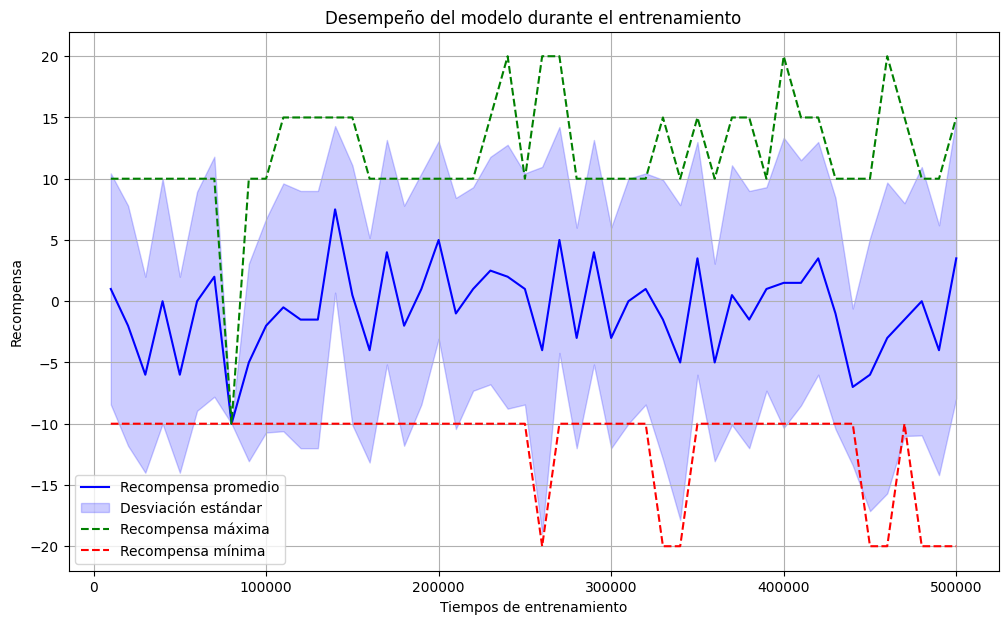

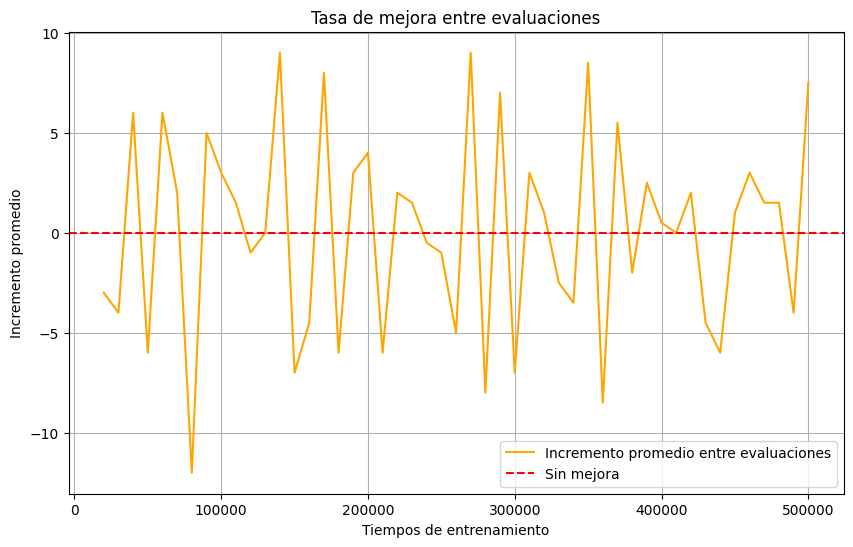

Estabilidad de las últimas recompensas (desviación estándar): 3.47
Porcentaje de evaluaciones con recompensa promedio > 0.8: 38.00%
El mejor modelo se obtuvo en el timestep 140000 con una recompensa promedio de 7.50


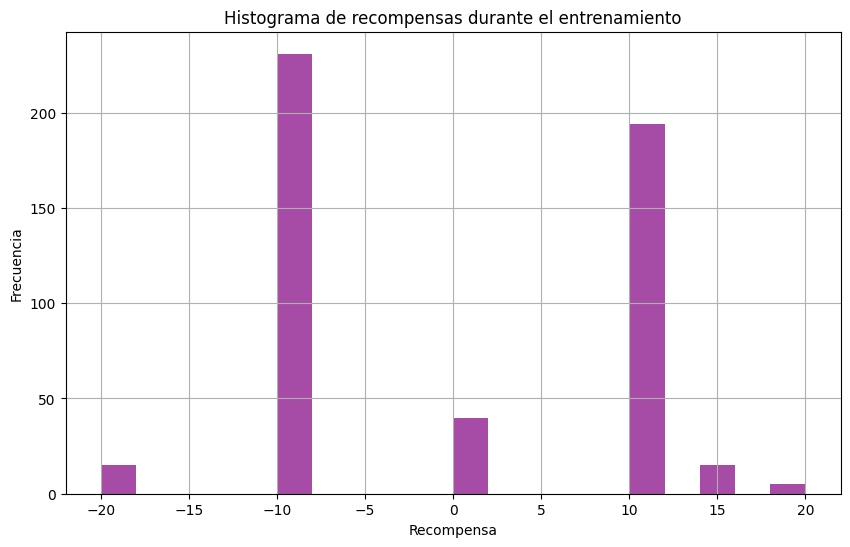

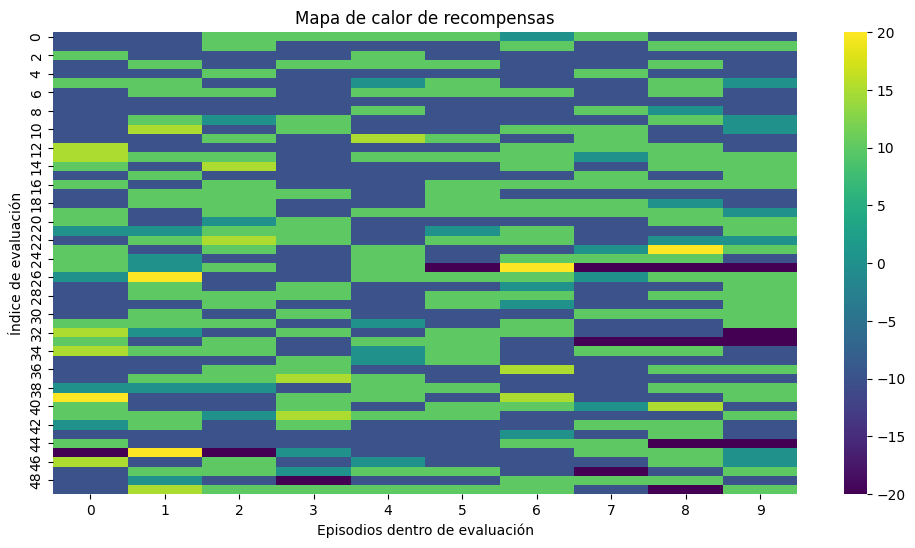

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos del archivo de evaluaciones
log_path = "./logs_qrdqn/evaluations.npz"
data = np.load(log_path)

# Extraer información relevante
timesteps = data["timesteps"]
mean_rewards = data["results"].mean(axis=1)
std_rewards = data["results"].std(axis=1)
max_rewards = data["results"].max(axis=1)
min_rewards = data["results"].min(axis=1)

# Graficar el desempeño del modelo con promedio, desviación estándar, máximo y mínimo
plt.figure(figsize=(12, 7))
plt.plot(timesteps, mean_rewards, label="Recompensa promedio", color="b")
plt.fill_between(
    timesteps,
    mean_rewards - std_rewards,
    mean_rewards + std_rewards,
    alpha=0.2,
    label="Desviación estándar",
    color="b"
)
plt.plot(timesteps, max_rewards, label="Recompensa máxima", linestyle="--", color="g")
plt.plot(timesteps, min_rewards, label="Recompensa mínima", linestyle="--", color="r")
plt.xlabel("Tiempos de entrenamiento")
plt.ylabel("Recompensa")
plt.title("Desempeño del modelo durante el entrenamiento")
plt.legend()
plt.grid()
plt.show()

# Tasa de mejora promedio entre evaluaciones
mean_diff = np.diff(mean_rewards)
plt.figure(figsize=(10, 6))
plt.plot(timesteps[1:], mean_diff, label="Incremento promedio entre evaluaciones", color="orange")
plt.axhline(0, color="red", linestyle="--", label="Sin mejora")
plt.xlabel("Tiempos de entrenamiento")
plt.ylabel("Incremento promedio")
plt.title("Tasa de mejora entre evaluaciones")
plt.legend()
plt.grid()
plt.show()

# Estabilidad en las últimas evaluaciones
last_rewards = data["results"][-10:]
last_variance = np.std(mean_rewards[-10:])
print(f"Estabilidad de las últimas recompensas (desviación estándar): {last_variance:.2f}")

# Porcentaje de evaluaciones que superan un umbral de recompensa
threshold = 0.8
above_threshold = np.sum(mean_rewards > threshold) / len(mean_rewards) * 100
print(f"Porcentaje de evaluaciones con recompensa promedio > {threshold}: {above_threshold:.2f}%")

# Identificar el mejor modelo y cuándo se obtuvo
best_eval_idx = np.argmax(mean_rewards)
best_timestep = timesteps[best_eval_idx]
best_mean_reward = mean_rewards[best_eval_idx]
print(f"El mejor modelo se obtuvo en el timestep {best_timestep} con una recompensa promedio de {best_mean_reward:.2f}")

# Histograma de recompensas
all_rewards = data["results"].flatten()
plt.figure(figsize=(10, 6))
plt.hist(all_rewards, bins=20, alpha=0.7, color="purple")
plt.xlabel("Recompensa")
plt.ylabel("Frecuencia")
plt.title("Histograma de recompensas durante el entrenamiento")
plt.grid()
plt.show()

# Mapa de calor de recompensas
plt.figure(figsize=(12, 6))
sns.heatmap(data["results"], cmap="viridis", cbar=True)
plt.xlabel("Episodios dentro de evaluación")
plt.ylabel("Índice de evaluación")
plt.title("Mapa de calor de recompensas")
plt.show()

In [ ]:
# Subir archivo a Colab
from google.colab import files

# Subir el archivo
uploaded = files.upload()

# Verificar los archivos subidos
for filename in uploaded.keys():
    print(f"Archivo subido: {filename}")

Saving qrdqn_blackjack.zip to qrdqn_blackjack.zip
Archivo subido: qrdqn_blackjack.zip


Se han truncado las últimas 5000 líneas del flujo de salida.
[ADJUST BET] Nueva apuesta establecida: 10

--- Episodio 99680 ---
Recompensa total en el episodio 99680: -10
[DRAW CARD] Carta robada: 8
[DRAW CARD] Carta robada: 4
[DRAW CARD] Carta robada: 10
[RESET] Mano del jugador: [8, 4], Carta del dealer: 10
[ACTION] Hit
[DRAW CARD] Carta robada: 10
[PLAYER] Carta añadida: 10, Mano actual: [8, 4, 10]
[PLAYER] Mano alcanza o supera 21, turno finalizado.
[PLAYER] Mano se pasa de 21, dealer gana automáticamente.
[TRUE COUNT] Remaining decks: 6.230769230769231, Running count: -4, True count: -0.32098765432098764
[ADJUST BET] Nueva apuesta establecida: 10

--- Episodio 99681 ---
Recompensa total en el episodio 99681: 15.0
[DRAW CARD] Carta robada: 10
[DRAW CARD] Carta robada: 1
[DRAW CARD] Carta robada: 10
[RESET] Mano del jugador: [10, 1], Carta del dealer: 10
[PLAYER] Blackjack detectado, paso al dealer.
[DRAW CARD] Carta robada: 3
[DEALER] Carta 2 del dealer: 3
[DEALER] Cartas del deale

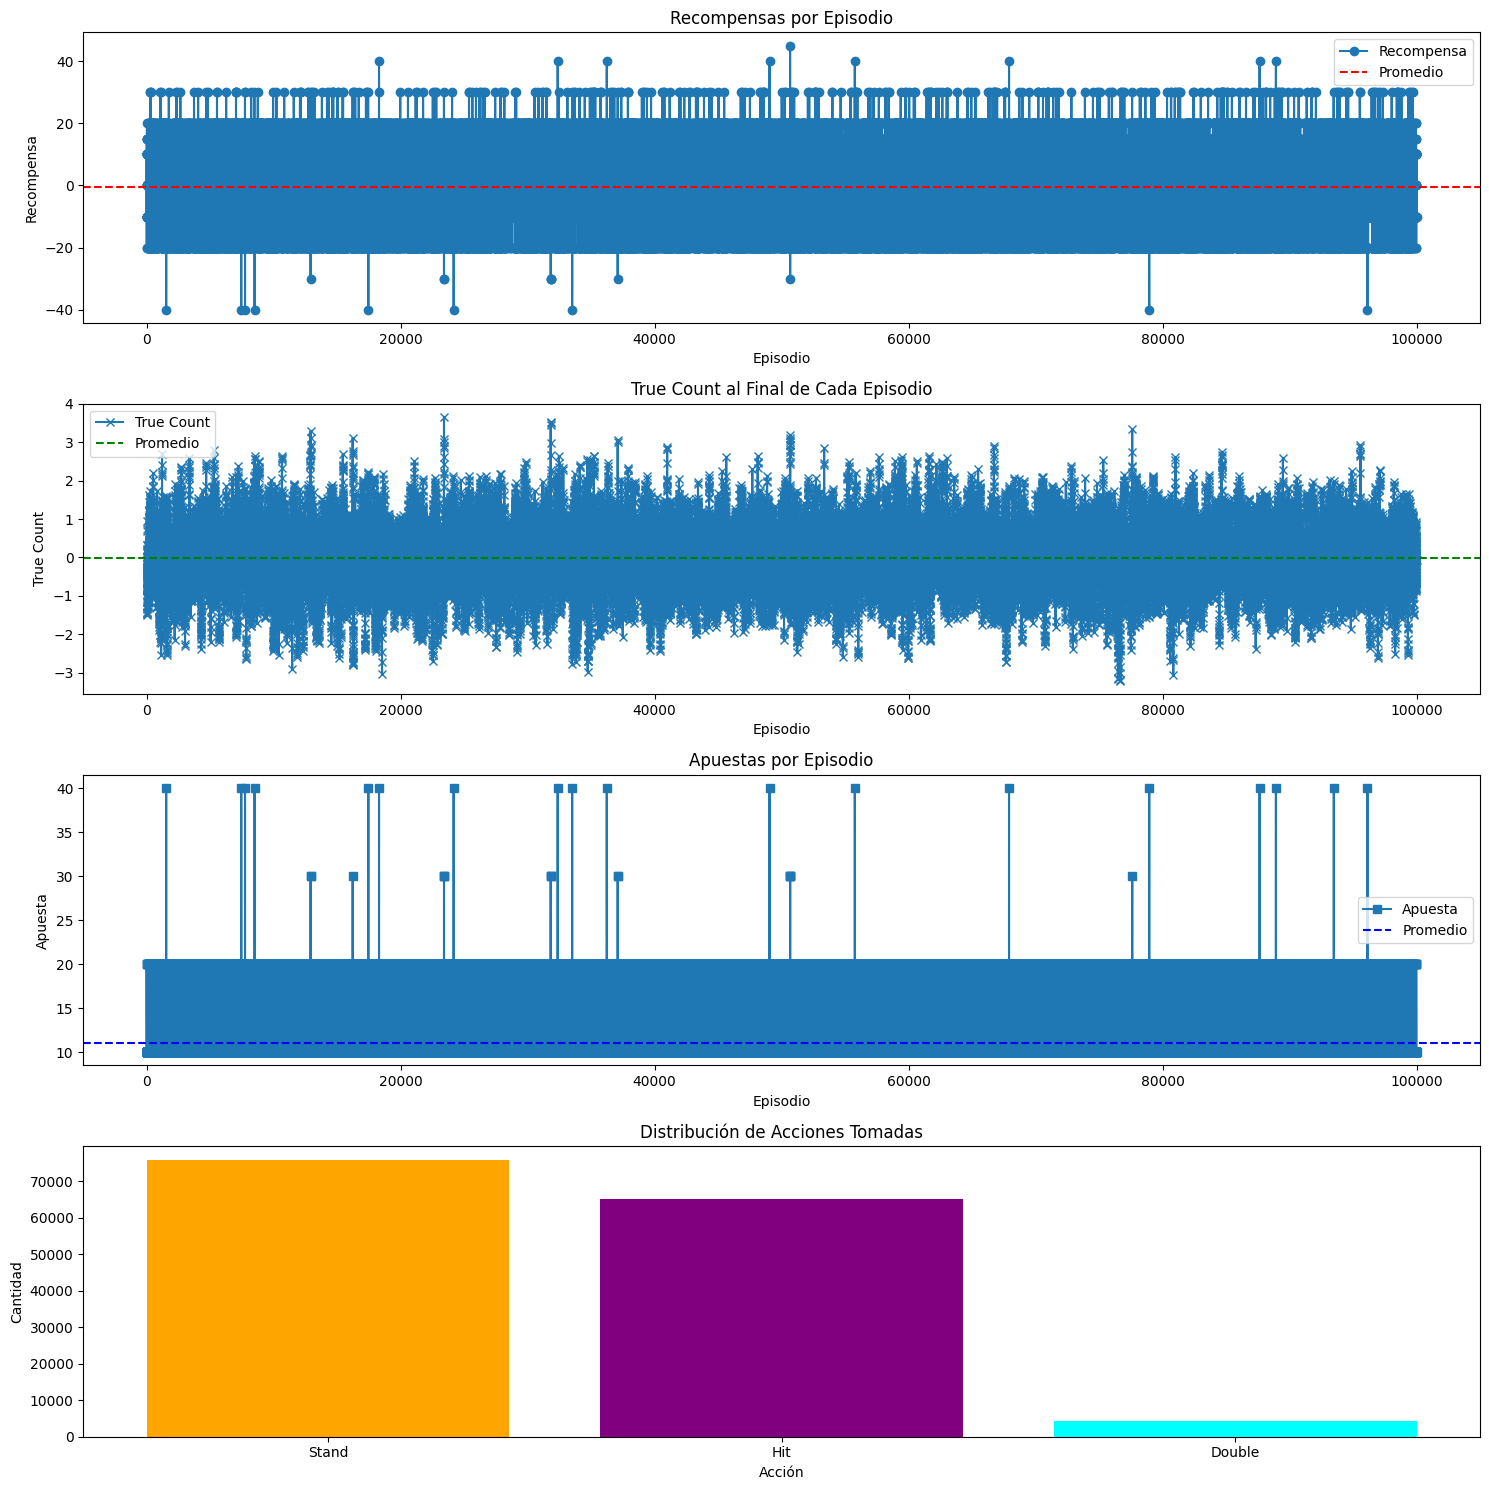

In [ ]:
from sb3_contrib import QRDQN
from collections import Counter
import matplotlib.pyplot as plt

# Cargar el modelo entrenado
model = QRDQN.load("qrdqn_blackjack.zip")

# Evaluar el modelo y registrar métricas
num_episodes = 100000
rewards = []       # Lista para recompensas por episodio
true_counts = []   # Lista para True Count al final de cada episodio
bets = []          # Lista para apuestas por episodio
actions_count = Counter({"Stand": 0, "Hit": 0, "Double": 0})  # Contador de acciones
bust_count = 0     # Contador de veces que el jugador se pasa de 21

obs, _ = env.reset()
for episode in range(num_episodes):
    obs, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, _ = env.step(action)
        total_reward += reward

        # Registrar la acción tomada
        if action == 0:
            actions_count["Stand"] += 1
        elif action == 1:
            actions_count["Hit"] += 1
        elif action == 2:
            actions_count["Double"] += 1

        # Verificar si el jugador se pasa de 21 usando el estado (obs)
        player_sum = obs[0]  # Asegúrate de que obs[0] representa la suma de la mano del jugador
        if player_sum > 21:
            bust_count += 1

    # Registrar métricas al final del episodio
    rewards.append(total_reward)
    true_counts.append(env.true_count)
    bets.append(env.current_bet)

    # Imprimir log del episodio
    print(f"\n--- Episodio {episode + 1} ---")
    print(f"Recompensa total en el episodio {episode + 1}: {total_reward}")
    for log_entry in env.log:
        print(log_entry)
    env.log = []  # Limpiar el registro para la próxima ronda

# Calcular victorias, derrotas y empates
wins = len([r for r in rewards if r > 0])
losses = len([r for r in rewards if r < 0])
draws = len([r for r in rewards if r == 0])

# Análisis de las métricas
print("\n--- Resumen de resultados ---")
print(f"Episodios totales: {num_episodes}")
print(f"Victorias: {wins} ({(wins / num_episodes) * 100:.2f}%)")
print(f"Derrotas: {losses} ({(losses / num_episodes) * 100:.2f}%)")
print(f"Empates: {draws} ({(draws / num_episodes) * 100:.2f}%)")
print(f"Recompensa total: {sum(rewards):.2f}")
print(f"Recompensa promedio por episodio: {np.mean(rewards):.2f}")
print("\nAcciones tomadas:")
print(f"Stand: {actions_count['Stand']}")
print(f"Hit: {actions_count['Hit']}")
print(f"Double: {actions_count['Double']}")
print(f"Veces que el jugador se pasa de 21: {bust_count}")

# Generar gráficos de métricas
plt.figure(figsize=(15, 15))

# Gráfico 1: Recompensas por episodio
plt.subplot(4, 1, 1)
plt.plot(range(1, num_episodes + 1), rewards, marker='o', linestyle='-', label="Recompensa")
plt.axhline(y=np.mean(rewards), color='r', linestyle='--', label="Promedio")
plt.title("Recompensas por Episodio")
plt.xlabel("Episodio")
plt.ylabel("Recompensa")
plt.legend()

# Gráfico 2: True Count por episodio
plt.subplot(4, 1, 2)
plt.plot(range(1, num_episodes + 1), true_counts, marker='x', linestyle='-', label="True Count")
plt.axhline(y=np.mean(true_counts), color='g', linestyle='--', label="Promedio")
plt.title("True Count al Final de Cada Episodio")
plt.xlabel("Episodio")
plt.ylabel("True Count")
plt.legend()

# Gráfico 3: Apuestas por episodio
plt.subplot(4, 1, 3)
plt.plot(range(1, num_episodes + 1), bets, marker='s', linestyle='-', label="Apuesta")
plt.axhline(y=np.mean(bets), color='b', linestyle='--', label="Promedio")
plt.title("Apuestas por Episodio")
plt.xlabel("Episodio")
plt.ylabel("Apuesta")
plt.legend()

# Gráfico 4: Distribución de acciones
plt.subplot(4, 1, 4)
actions_labels = ["Stand", "Hit", "Double"]
actions_values = [actions_count["Stand"], actions_count["Hit"], actions_count["Double"]]
plt.bar(actions_labels, actions_values, color=['orange', 'purple', 'cyan'])
plt.title("Distribución de Acciones Tomadas")
plt.xlabel("Acción")
plt.ylabel("Cantidad")

plt.tight_layout()
plt.show()